<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-best-parameters-for-each-model" data-toc-modified-id="Load-the-best-parameters-for-each-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the best parameters for each model</a></span></li><li><span><a href="#Modeling-Results" data-toc-modified-id="Modeling-Results-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling Results</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Ridge-Classifier" data-toc-modified-id="Ridge-Classifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Ridge Classifier</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Gradient-Boosting" data-toc-modified-id="Gradient-Boosting-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Gradient Boosting</a></span></li><li><span><a href="#Support-Vector-Machine" data-toc-modified-id="Support-Vector-Machine-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Support Vector Machine</a></span></li><li><span><a href="#Gaussian-Naive-Bayes" data-toc-modified-id="Gaussian-Naive-Bayes-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Gaussian Naive Bayes</a></span></li><li><span><a href="#K-Nearest-Neighbors" data-toc-modified-id="K-Nearest-Neighbors-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>K-Nearest Neighbors</a></span></li></ul></li><li><span><a href="#Comparison-of-Recall-Scores" data-toc-modified-id="Comparison-of-Recall-Scores-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparison of Recall Scores</a></span></li><li><span><a href="#Confusion-Matrix-for-GB-and-KNN" data-toc-modified-id="Confusion-Matrix-for-GB-and-KNN-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Confusion Matrix for GB and KNN</a></span></li><li><span><a href="#ROC-AUC-Curve" data-toc-modified-id="ROC-AUC-Curve-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>ROC AUC Curve</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import Functions as fxns
%matplotlib inline
sns.set(rc={'axes.facecolor':'#d0ece4', 'figure.facecolor':'#d0ece4'})

sns.set_palette("Set1")
plt.rcParams['figure.figsize'] = (7, 7)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings(action="ignore")

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, recall_score, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.utils.class_weight import compute_sample_weight
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

In [3]:
# Load data
providers = joblib.load('./Ryan/providers_last.pkl')
providers = providers.set_index('Provider')

# Separate input features (X) and target variable (y)
y = providers['PotentialFraud']
X = providers.drop('PotentialFraud', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = 0)

# Stratified Cross Validation needs to be applied
skf = StratifiedKFold(n_splits = 10, random_state = 0, shuffle = True)

# Apply Scaling
scaler = MinMaxScaler()
X_train_stan = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_stan = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# Load the best parameters for each model

In [4]:
best_logistic_reg = joblib.load('./Best_Params/bestLogReg.pkl')
best_ridge = joblib.load('./Best_Params/best_ridge.pkl')
best_rf = joblib.load('./Best_Params/best_rf.pkl')
best_gb = joblib.load('./Best_Params/best_gb.pkl')
best_svm = joblib.load('./Best_Params/best_svm.pkl')
best_gnb = joblib.load('./Best_Params/best_gnb.pkl')
best_knn = joblib.load('./Best_Params/bestKNN.pkl')

# Modeling Results

## Logistic Regression

In [5]:
fxns.eval_model('Logistic Regression', best_logistic_reg, X_train_stan, X_test_stan, y_train, y_test)

Logistic Regression score
------------------------------
Train: recall score: 0.91808
Test: recall score: 0.91447
 
Train Test Confusion Matrix
------------------------------
Train Set
[[2576  857]
 [  29  325]]
Test Set
[[1117  354]
 [  13  139]]


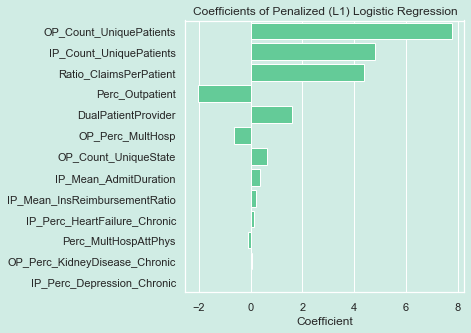

In [9]:
logistic_coef = pd.DataFrame(best_logistic_reg.coef_.T, index = X.columns).rename(columns = {0:"Coef."})
logistic_coef = logistic_coef.reindex(logistic_coef["Coef."].abs().sort_values(ascending = False).index)
logistic_coef = logistic_coef.reset_index()
plt.figure(figsize = (5,5))
sns.barplot(data = logistic_coef[logistic_coef['Coef.'].abs() > 0], x = 'Coef.', y = 'index', color = '#53dc98');
plt.title('Coefficients of Penalized (L1) Logistic Regression');
plt.xlabel('Coefficient');
plt.ylabel('');

## Ridge Classifier

In [10]:
reduced_features = logistic_coef[logistic_coef['Coef.'].abs() > 0]['index'].tolist()
X_train_reduced = X_train_stan.iloc[:,X_train_stan.columns.isin(reduced_features)]
X_test_reduced = X_test_stan.iloc[:,X_test_stan.columns.isin(reduced_features)]

In [11]:
fxns.eval_model('Ridge Classifier', best_ridge, X_train_reduced, X_test_reduced, y_train, y_test)

Ridge Classifier score
------------------------------
Train: recall score: 0.92938
Test: recall score: 0.91447
 
Train Test Confusion Matrix
------------------------------
Train Set
[[2590  843]
 [  25  329]]
Test Set
[[1135  336]
 [  13  139]]


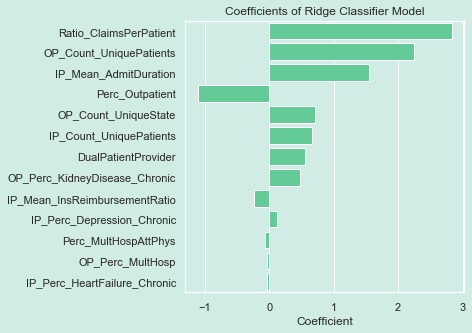

In [12]:
ridge_coef = pd.DataFrame(best_ridge.coef_.T, index = X_train_reduced.columns).rename(columns = {0:"Coef."})
ridge_coef = ridge_coef.reindex(ridge_coef["Coef."].abs().sort_values(ascending = False).index)
ridge_coef = ridge_coef.reset_index()
plt.figure(figsize = (5,5))
sns.barplot(data = ridge_coef, x = 'Coef.', y = 'index', color = '#53dc98');
plt.title('Coefficients of Ridge Classifier Model');
plt.xlabel('Coefficient');
plt.ylabel('');

## Random Forest

In [13]:
fxns.eval_model('Random Forest', best_rf, X_train, X_test, y_train, y_test)

Random Forest score
------------------------------
Train: recall score: 0.9096
Test: recall score: 0.90132
 
Train Test Confusion Matrix
------------------------------
Train Set
[[2822  611]
 [  32  322]]
Test Set
[[1233  238]
 [  15  137]]


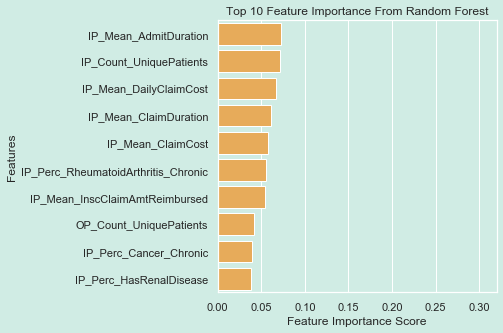

In [14]:
sorted_importance = sorted(zip(X_train.columns, best_rf.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*sorted_importance)
plt.figure(figsize = (5,5))
df = pd.DataFrame({'feature_name':a, 'importance_score':b}).head(10)
sns.barplot(data = df, x = 'importance_score', y= 'feature_name', orient = 'h', color = '#ffae42');
plt.title('Top 10 Feature Importance From Random Forest');
plt.xlabel('Feature Importance Score');
plt.ylabel('Features');
plt.xlim(0,0.32);

## Gradient Boosting

In [15]:
fxns.eval_model('Gradient Boosting', best_gb, X_train, X_test, y_train, y_test)

Gradient Boosting score
------------------------------
Train: recall score: 0.92655
Test: recall score: 0.92105
 
Train Test Confusion Matrix
------------------------------
Train Set
[[2956  477]
 [  26  328]]
Test Set
[[1285  186]
 [  12  140]]


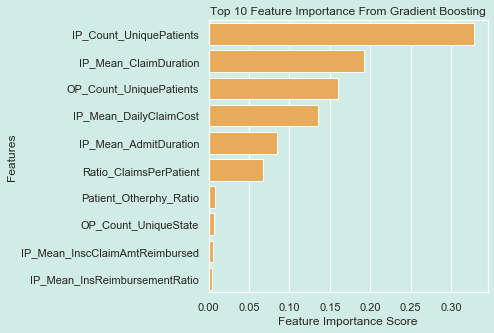

In [16]:
sorted_importance = sorted(zip(X_train.columns, best_gb.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*sorted_importance)
plt.figure(figsize = (5,5))
df = pd.DataFrame({'feature_name':a, 'importance_score':b}).head(10)
sns.barplot(data = df, x = 'importance_score', y= 'feature_name', orient = 'h', color = '#ffae42');
plt.title('Top 10 Feature Importance From Gradient Boosting');
plt.xlabel('Feature Importance Score');
plt.ylabel('Features');

## Support Vector Machine

In [17]:
fxns.eval_model('SVM', best_svm, X_train_stan, X_test_stan, y_train, y_test)

SVM score
------------------------------
Train: recall score: 0.92938
Test: recall score: 0.92763
 
Train Test Confusion Matrix
------------------------------
Train Set
[[2536  897]
 [  25  329]]
Test Set
[[1114  357]
 [  11  141]]


## Gaussian Naive Bayes

In [18]:
fxns.eval_model('GNB', best_gnb, X_train_stan, X_test_stan, y_train, y_test)

GNB score
------------------------------
Train: recall score: 0.88418
Test: recall score: 0.86842
 
Train Test Confusion Matrix
------------------------------
Train Set
[[2341 1092]
 [  41  313]]
Test Set
[[1044  427]
 [  20  132]]


## K-Nearest Neighbors

In [19]:
oversample = SMOTE(random_state=0)
X_train_smote, y_train_smote = oversample.fit_resample(X_train_stan, y_train)

In [20]:
fxns.eval_model('KNN', best_knn, X_train_smote, X_test_stan, y_train_smote, y_test)

KNN score
------------------------------
Train: recall score: 0.9898
Test: recall score: 0.96053
 
Train Test Confusion Matrix
------------------------------
Train Set
[[2259 1174]
 [  35 3398]]
Test Set
[[970 501]
 [  6 146]]


# Comparison of Recall Scores

In [22]:
recall_scores = pd.DataFrame([[recall_score(y_train, best_gnb.predict(X_train_stan)),
                               recall_score(y_test, best_gnb.predict(X_test_stan))],
                              [recall_score(y_train, best_rf.predict(X_train)),
                              recall_score(y_test, best_rf.predict(X_test))],
                              [recall_score(y_train,best_logistic_reg.predict(X_train_stan)), 
                               recall_score(y_test,best_logistic_reg.predict(X_test_stan))],
                              [recall_score(y_train, best_ridge.predict(X_train_reduced)),
                              recall_score(y_test, best_ridge.predict(X_test_reduced))],
                              [recall_score(y_train, best_gb.predict(X_train)),
                              recall_score(y_test, best_gb.predict(X_test))],
                              [recall_score(y_train,best_svm.predict(X_train_stan)), 
                               recall_score(y_test,best_svm.predict(X_test_stan))],
                              [recall_score(y_train_smote, best_knn.predict(X_train_smote)),
                               recall_score(y_test, best_knn.predict(X_test_stan))]],
                            index = ['Naive Bayes','Random Forest','L1 Logistic Reg.',
                                     'Ridge Classifier','Gradient Boosting',
                                     'SVM','KNN'],
                            columns = ['Train','Test'])

In [23]:
recall_scores = pd.DataFrame(recall_scores.unstack()).reset_index()
recall_scores.columns = ['tt','model','score']

In [25]:
# train1 = mpatches.Patch(color='#7ee5b1', label='', alpha=0.5)
# test1 = mpatches.Patch(color='#53dc98', label='')
# train2 = mpatches.Patch(color='#ffae42', label='', alpha=0.5)
# test2 = mpatches.Patch(color='#ff980f', label='')
# train3 = mpatches.Patch(color='#5E2D79', label='Train', alpha=0.5)
# test3 = mpatches.Patch(color='#510979', label='Test')
# handles = [train1, test1, train2, test2, train3, test3]

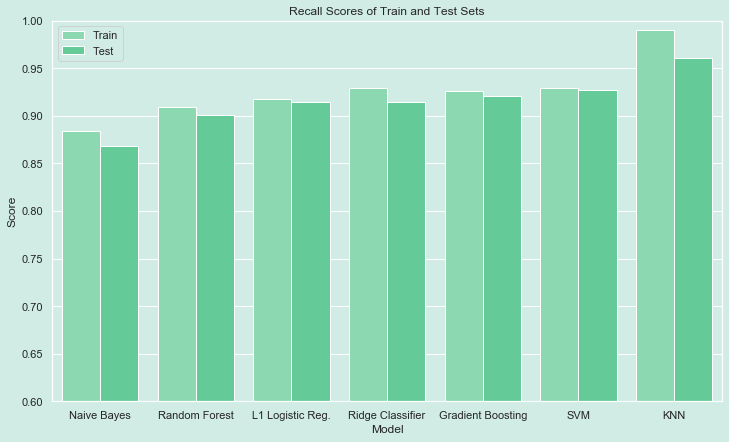

In [25]:
plt.figure(figsize = (12,7))
sns.barplot(data = recall_scores, x = 'model', y = 'score', hue = 'tt', palette = ['#7ee5b1','#53dc98']);
plt.title('Recall Scores of Train and Test Sets');
plt.xlabel('Model');
plt.ylabel('Score');
plt.ylim(0.6,1.0);
plt.legend().set_title("")
# plt.legend(handles=handles, ncol = 3).set_title("")

# Confusion Matrix for GB and KNN

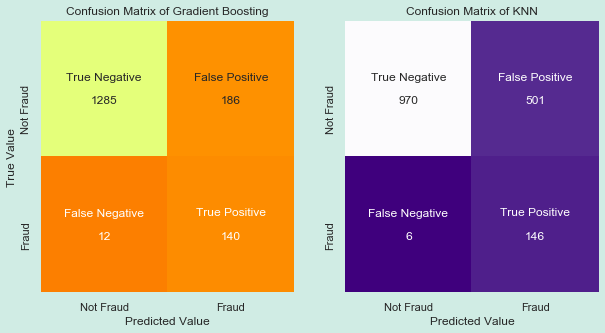

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
gb_matrix = confusion_matrix(y_test, best_gb.predict(X_test))
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in gb_matrix.flatten()]
labels = [f'{v1}\n\n{v2}' for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(gb_matrix, annot=labels, fmt='', cmap='Wistia_r', cbar = False,
           xticklabels=['Not Fraud','Fraud'], yticklabels=['Not Fraud','Fraud'], ax = ax[0]);
ax[0].set_title('Confusion Matrix of Gradient Boosting');
ax[0].set_xlabel('Predicted Value');
ax[0].set_ylabel('True Value');

knn_matrix = confusion_matrix(y_test, best_knn.predict(X_test_stan))
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in knn_matrix.flatten()]
labels = [f'{v1}\n\n{v2}' for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(gb_matrix, annot=labels, fmt='', cmap='Purples_r', cbar = False,
           xticklabels=['Not Fraud','Fraud'], yticklabels=['Not Fraud','Fraud'], ax = ax[1]);
ax[1].set_title('Confusion Matrix of KNN');
ax[1].set_xlabel('Predicted Value');
ax[1].set_ylabel('');

# ROC AUC Curve

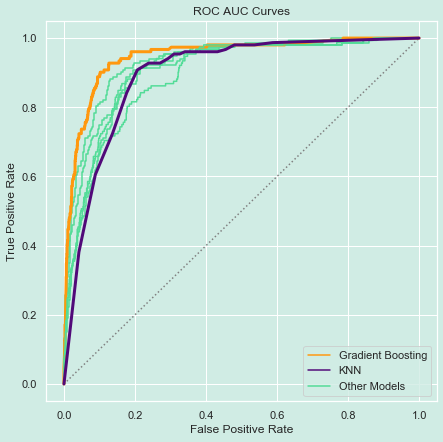

In [27]:
random_probs = [0 for i in range(len(y_test))]
fpr, tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
pred_logistic = best_logistic_reg.predict_proba(X_test_stan)[:,1]
logistic_fpr, logistic_tpr, _ = roc_curve(y_test, pred_logistic)
pred_ridge = best_ridge.decision_function(X_test_reduced)
ridge_fpr, ridge_tpr, _ = roc_curve(y_test, pred_ridge)
pred_rf = best_rf.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, pred_rf)
pred_gb = best_gb.predict_proba(X_test)[:,1]
gb_fpr, gb_tpr, _ = roc_curve(y_test, pred_gb)
pred_svm = best_svm.predict_proba(X_test_stan)[:,1]
svm_fpr, svm_tpr, _ = roc_curve(y_test, pred_svm)
pred_gnb = best_gnb.predict_proba(X_test_stan)[:,1]
gnb_fpr, gnb_tpr, _ = roc_curve(y_test, pred_gnb)
pred_knn = best_knn.predict_proba(X_test_stan)[:,1]
knn_fpr, knn_tpr, _ = roc_curve(y_test, pred_knn)


# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle = ':', color = 'gray');
plt.plot(logistic_fpr, logistic_tpr, label='Logistic Regression', color = '#53dc98');
plt.plot(ridge_fpr, ridge_tpr, label='Ridge Classifier', color = '#53dc98');
plt.plot(rf_fpr, rf_tpr, label='Random Forest', color = '#53dc98');
plt.plot(gb_fpr, gb_tpr, label='Gradient Boosting', color = '#ff980f', linewidth = 3);
plt.plot(svm_fpr, svm_tpr, label='SVM', color = '#53dc98');
plt.plot(gnb_fpr, gnb_tpr, label='GNB', color = '#53dc98');
plt.plot(knn_fpr, knn_tpr, label='KNN', color = '#510979', linewidth = 3);

line1 = Line2D([0],[0],color='#ff980f', label='Gradient Boosting')
line2 = Line2D([0],[0],color='#510979', label='KNN')
line3 = Line2D([0],[0],color='#53dc98', label='Other Models')
handles = [line1, line2, line3]
plt.legend(handles=handles, ncol = 1).set_title("")
plt.title('ROC AUC Curves')
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');

In [30]:
roc_auc = pd.DataFrame(
   [['GNB',roc_auc_score(y_test, best_gnb.predict(X_test_stan))],
    ['KNN',roc_auc_score(y_test, best_knn.predict(X_test_stan))],
    ['LR (L1)', roc_auc_score(y_test, best_logistic_reg.predict(X_test_stan))],
    ['SVM',roc_auc_score(y_test, best_svm.predict(X_test_stan))],
    ['Ridge', roc_auc_score(y_test, best_ridge.predict(X_test_reduced))],
    ['RF', roc_auc_score(y_test, best_rf.predict(X_test))],
    ['GB',roc_auc_score(y_test, best_gb.predict(X_test))]],
    columns = ['Model','ROC_AUC_Score'])

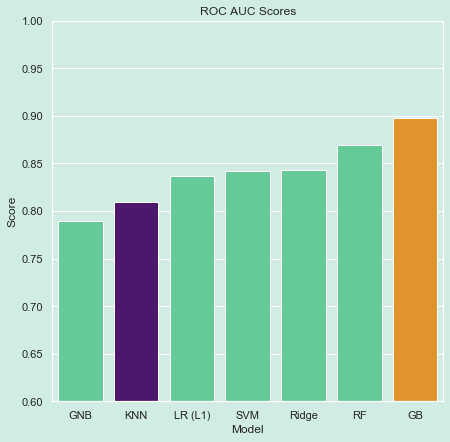

In [31]:
sns.barplot(data = roc_auc, x = 'Model', y = 'ROC_AUC_Score', 
            palette = ['#53dc98','#510979','#53dc98','#53dc98','#53dc98','#53dc98','#ff980f']);
plt.title('ROC AUC Scores');
plt.xlabel('Model');
plt.ylabel('Score');
plt.ylim(0.6,1.0);